# Подбор параметров (автоматизированно)

In [51]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import time
import numpy as np
from typing import Callable
import random
import math
import matplotlib.pyplot as plt
import copy
import optuna

from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE

import nevergrad as ng

import cma

from continuous_ga_core.clusterization import *
from continuous_ga_core.crossover import *
from continuous_ga_core.evaluation import *
from continuous_ga_core.crossover import *
from continuous_ga_core.evaluation import *
from continuous_ga_core.interaction import *
from continuous_ga_core.logger import *
from continuous_ga_core.mutation import *
from continuous_ga_core.pipeline import *
from continuous_ga_core.population import *
from continuous_ga_core.selection import *
from continuous_ga_core.termination import *
from continuous_ga_core.visualization import *
from utils.visualization import show_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Библиотечные функции оптимизации

In [21]:
def run_with_time_limit(
        f: Callable[[np.ndarray], float],
        optimizer_step,
        time_limit: float
):
    """
    Универсальный тайм-лимитер для оптимизаторов без встроенного time_budget.
    """
    start = time.time()
    best_x, best_f = None, float("inf")

    while time.time() - start < time_limit:
        x = optimizer_step()
        fx = f(x)
        if fx < best_f:
            best_x, best_f = x, fx

    return best_x, best_f


def optimize_pymoo(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        time_limit: float = None,
        eval_budget: int = None,
        seed: int = 1
):
    class Problem(ElementwiseProblem):
        def __init__(self):
            super().__init__(
                n_var=dimension,
                n_obj=1,
                xl=bounds[0],
                xu=bounds[1]
            )

        def _evaluate(self, x, out, *args, **kwargs):
            out["F"] = f(x)

    algorithm = DE(pop_size=10 * dimension)

    termination = None
    if time_limit is not None:
        termination = ("time", time_limit)
    elif eval_budget is not None:
        termination = ("n_eval", eval_budget)

    res = minimize(
        Problem(),
        algorithm,
        termination=termination,
        seed=seed,
        verbose=False
    )

    return res.X, res.F[0]


def optimize_nevergrad(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        budget: int,
        optimizer_name: str = "NGOpt",
        num_workers: int = 1
):
    parametrization = ng.p.Array(
        shape=(dimension,)
    ).set_bounds(bounds[0], bounds[1])

    optimizer_cls = getattr(ng.optimizers, optimizer_name)

    optimizer = optimizer_cls(
        parametrization=parametrization,
        budget=budget,
        num_workers=num_workers
    )

    recommendation = optimizer.minimize(f)

    return recommendation.value, recommendation.loss


def optimize_pycma(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        eval_budget: int,
        sigma: float = 100.0,
        seed: int = 1
):
    x0 = np.zeros(dimension)

    es = cma.CMAEvolutionStrategy(
        x0,
        sigma,
        {
            "bounds": [bounds[0], bounds[1]],
            "maxfevals": eval_budget,
            "seed": seed,
            "verbose": -9
        }
    )

    es.optimize(f)

    x_best = es.result.xbest
    f_best = es.result.fbest

    return x_best, f_best


class LoggedProblem(ElementwiseProblem):
    def __init__(self, f, n, bounds, history):
        super().__init__(n_var=n, n_obj=1, xl=bounds[0], xu=bounds[1])
        self.f = f
        self.history = history
        self.best = float("inf")

    def _evaluate(self, x, out, *args, **kwargs):
        fx = self.f(x)
        self.best = min(self.best, fx)
        self.history.append(self.best)
        out["F"] = fx


def run_pymoo_with_history(f, n, bounds, eval_budget):
    history = []

    problem = LoggedProblem(f, n, bounds, history)

    minimize(
        problem,
        DE(pop_size=10 * n),
        termination=("n_eval", eval_budget),
        verbose=False
    )

    return history, history[-1]


def run_nevergrad_with_history(f, n, bounds, budget):
    parametrization = ng.p.Array(shape=(n,)).set_bounds(bounds[0], bounds[1])
    optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=budget)

    best = float("inf")
    history = []

    for _ in range(budget):
        x = optimizer.ask()
        fx = float(f(x.value))
        optimizer.tell(x, fx)

        best = min(best, fx)
        history.append(max(best, 1e-12))  # защита для log-scale

    return history, history[-1]


def run_pycma_with_history(f, n, bounds, eval_budget, sigma=100.0):
    history = []

    def callback(es):
        history.extend(
            [es.result.fbest] * es.popsize
        )

    es = cma.CMAEvolutionStrategy(
        np.zeros(n),
        sigma,
        {
            "bounds": [bounds[0], bounds[1]],
            "maxfevals": eval_budget,
            "verbose": -9
        }
    )

    es.optimize(f, callback=callback)

    return history[:eval_budget], history[:eval_budget][-1]


def plot_convergence(histories, labels, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    # --- Линейный график ---
    for hist, label in zip(histories, labels):
        axes[0].plot(hist, label=label)

    axes[0].set_xlabel("Iteration / Evaluation")
    axes[0].set_ylabel("Best f(x) so far")
    axes[0].set_title("Convergence (linear scale)")
    axes[0].grid(True)
    axes[0].legend()

    # --- Логарифмический график ---
    for hist, label in zip(histories, labels):
        axes[1].plot(hist, label=label)

    axes[1].set_yscale("log")
    axes[1].set_xlabel("Iteration / Evaluation")
    axes[1].set_ylabel("Best f(x) so far")
    axes[1].set_title("Convergence (log scale)")
    axes[1].grid(True)
    axes[1].legend()

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Классический ГА и шаблоны ГА с видообразованием

In [211]:
ga = GeneticAlgorithm(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    termination_fn=termination_by_generation
)

gas = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.7,
        min_samples=10
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.4,
        gamma=0.2,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_db_template = GeneticAlgorithmWithSpeciationFast(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.7,
        min_samples=10
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.8,
        gamma=0.5,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_template = gas_db_template

## Функции подбора параметров

Общие ограничения на параметры:

In [4]:
SEARCH_SPACE = {
    "eps": (0.3, 2.0),
    "min_samples": (5, 30),
    "alpha": (-1.0, 0.0),
    "gamma": (0.0, 1.0),
    "sigma": (0.3, 1.0)
}

#### Random Search

In [192]:
def evaluate_config(run_config, config, runs=3):
    scores = []

    for _ in range(runs):
        gas_ = copy.deepcopy(run_config["gas"])

        gas_.clusterization_fn = lambda pop: dbscan_clusterization_indices(
            population=pop,
            eps=config["eps"],
            min_samples=config["min_samples"]
        )

        gas_.interaction_fn = lambda pop, fit, sp: predator_prey_interaction_with_scale(
            population=pop,
            fitness=fit,
            species=sp,
            alpha=config["alpha"],
            gamma=config["gamma"],
            sigma=config["sigma"]
        )

        f_best, _ = gas_.run(run_config["population_size"], run_config["dimension"],
                             run_config["budget"], run_config["function"])
        scores.append(f_best)

    return np.median(scores)


def random_search(run_config, n_trials=50):
    best_score = float("inf")
    best_config = None

    for i in range(n_trials):
        config = {
            "eps": random.uniform(0.3, 1.0),
            "min_samples": random.randint(5, 30),
            "alpha": random.uniform(-1.0, 0.0),
            "gamma": random.uniform(0.0, 1.0),
            "sigma": random.uniform(0.3, 1.0),
        }

        score = evaluate_config(run_config, config)

        print(f"[{i}] score={score:.4e}, cfg={config}")

        if score < best_score:
            best_score = score
            best_config = config

    return best_config, best_score

#### Bayesian Optimization (Optuna)

In [213]:
def objective(run_config, trial):
    config = {
        #"eps": trial.suggest_float("eps", 0.3, 1.0),
        #"min_samples": trial.suggest_int("min_samples", 5, 30),
        "alpha": trial.suggest_float("alpha", -1.0, 0.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        #"sigma": trial.suggest_float("sigma", 0.3, 1.0),
    }

    scores = []

    for _ in range(3):
        gas_ = copy.deepcopy(run_config["gas"])

        gas_.clusterization_fn = lambda pop: dbscan_clusterization_indices(
            population=pop,
            eps=0.7,
            min_samples=10
        )

        gas_.interaction_fn = lambda pop, fit, sp: predator_prey_interaction_with_scale(
            population=pop,
            fitness=fit,
            species=sp,
            alpha=config["alpha"],
            gamma=config["gamma"],
            sigma=0.8
        )

        f_best, _ = gas_.run(run_config["population_size"], run_config["dimension"],
                             run_config["budget"], run_config["function"])
        scores.append(f_best)

    return np.median(scores)


def bayesian_optimization(run_config, n_trials=60):
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(n_startup_trials=10)
    )

    obj = lambda trial: objective(run_config, trial)
    study.optimize(obj, n_trials=n_trials)

    return study.best_params, study.best_value

#### CMA-ES

In [194]:
def fitness(run_config, theta):
    eps, alpha, gamma, sigma = theta
    min_samples = 14

    scores = []
    for _ in range(3):
        gas_ = copy.deepcopy(run_config["gas"])

        gas_.clusterization_fn = lambda pop: dbscan_clusterization_indices(
            population=pop,
            eps=np.clip(eps, 0.3, 1.0),
            min_samples=min_samples
        )

        gas_.interaction_fn = lambda pop, fit, sp: predator_prey_interaction_with_scale(
            population=pop,
            fitness=fit,
            species=sp,
            alpha=np.clip(alpha, -1.0, 0.0),
            gamma=np.clip(gamma, 0.0, 1.0),
            sigma=np.clip(sigma, 0.3, 1.0)
        )

        f_best, _ = gas_.run(run_config["population_size"], run_config["dimension"],
                             run_config["budget"], run_config["function"])
        scores.append(f_best)

    return np.median(scores)


def cma_optimization(run_config):
    es = cma.CMAEvolutionStrategy(
        x0=[0.9, -0.8, 0.5, 0.8],
        sigma0=0.2,
        inopts={"bounds": [[0.3, -1, 0, 0.3], [2.0, 0, 1, 1.0]]}
    )

    fitness_ = lambda theta: fitness(run_config, theta)
    es.optimize(fitness_, iterations=40)
    return es.result.xbest, es.result.fbest

## Подбор параметров

In [240]:
selection_config = {
    "gas": gas_template,
    "population_size": 200,
    "dimension": 10,
    "budget": 1000,
    "bounds": (-100, 100),
    "function": griewangks_function
}

# Мультимодальные функции:
# schwefels_function
# rastrigins_function
# solomons_function
# ackleys_function
# griewangks_function

# CEC2014:
# F202014
# F182014
# F172014
# F102014

# CEC2022:
# F42022
# F62022
# F92022
# F102022

In [ ]:
random.seed(241)
np.random.seed(241)

best_config_random, best_score_random = random_search(selection_config)
print(f"Random search best: {best_score_random}")
print(f"Random config: {best_config_random}")

In [ ]:
random.seed(241)
np.random.seed(241)

best_config_bayesian, best_score_bayesian = bayesian_optimization(selection_config, 100)
print(f"Bayesian search best: {best_score_bayesian}")
print(f"Bayesian config: {best_config_bayesian}")

[I 2026-02-04 18:05:49,475] A new study created in memory with name: no-name-eb79e4c9-06c0-4529-8ab8-0f524d477ac1


In [ ]:
random.seed(241)
np.random.seed(241)

best_config_cma, best_score_cma = cma_optimization(selection_config)
print(f"CMA search best: {best_score_cma}")
print(f"CMA config: {best_config_cma}")

## ГА с видообразованием с подобранными параметрами

In [231]:
gas_db_schwefel = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.9,
        min_samples=14
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.5,
        gamma=0.5,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_db_rastrigin = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.7,
        min_samples=10
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.2136690256300637,
        gamma=0.3992358878648691,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_db_solomon = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.4311773629680378,
        min_samples=10
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.06558432675793045,
        gamma=0.0793129804551977,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_db_ackley = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.7,
        min_samples=10
    ),
    role_assignment_fn=lambda sp: assign_roles_inverse_size(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction_with_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=-0.027927349689986888,
        gamma=0.15431115550275956,
        sigma=0.8
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

## Сравнение алгоритмов

In [232]:
run_config = {
    "population_size": 200,
    "dimension": 10,
    "budget": 2000,
    "bounds": (-100, 100),
    "function": ackleys_function
}

In [233]:
random.seed(241)
np.random.seed(241)
logger_ga = DataLogger()

f_best_ga, x_best_ga = ga.run(run_config["population_size"], run_config["dimension"],
                              run_config["budget"], run_config["function"], logger_ga)
print(f"GA best: {f_best_ga}")

min fitness: 20.229814969534285
Execution time 23.106 sec.
GA best: 20.229814969534285


In [234]:
random.seed(241)
np.random.seed(241)
logger_gas = DataLogger()

f_best_gas, x_best_gas = gas.run(run_config["population_size"], run_config["dimension"],
                                 run_config["budget"], run_config["function"], logger_gas)
print(f"GAS best: {f_best_gas}")

min fitness: 20.00337360280943
Execution time 62.169 sec.
GAS best: 20.01444975646757


In [235]:
random.seed(241)
np.random.seed(241)
logger_gas_s = DataLogger()

f_best_gas_s, x_best_gas_s = gas_db_ackley.run(run_config["population_size"],
                                                run_config["dimension"], run_config["budget"],
                                                run_config["function"], logger_gas_s)
print(f"GAS best: {f_best_gas_s}")

min fitness: 20.000000163349146
Execution time 108.314 sec.
GAS best: 20.000000671698785


In [236]:
random.seed(241)
np.random.seed(241)

hist_pymoo, f_best_pymoo = run_pymoo_with_history(
    run_config["function"], run_config["dimension"], run_config["bounds"], eval_budget=run_config["budget"]
)
print(f"pymoo best: {f_best_pymoo}")

pymoo best: 20.283322388275224


In [237]:
random.seed(241)
np.random.seed(241)

hist_ng, f_best_ng = run_nevergrad_with_history(
    run_config["function"], run_config["dimension"], run_config["bounds"], budget=run_config["budget"]
)
print(f"nevergrad best: {f_best_ng}")

nevergrad best: 20.48253235514457


In [238]:
random.seed(241)
np.random.seed(241)

hist_cma, f_best_cma = run_pycma_with_history(
    run_config["function"], run_config["dimension"], run_config["bounds"], eval_budget=run_config["budget"]
)
print(f"pycma best: {f_best_cma}")

pycma best:20.52139335980949


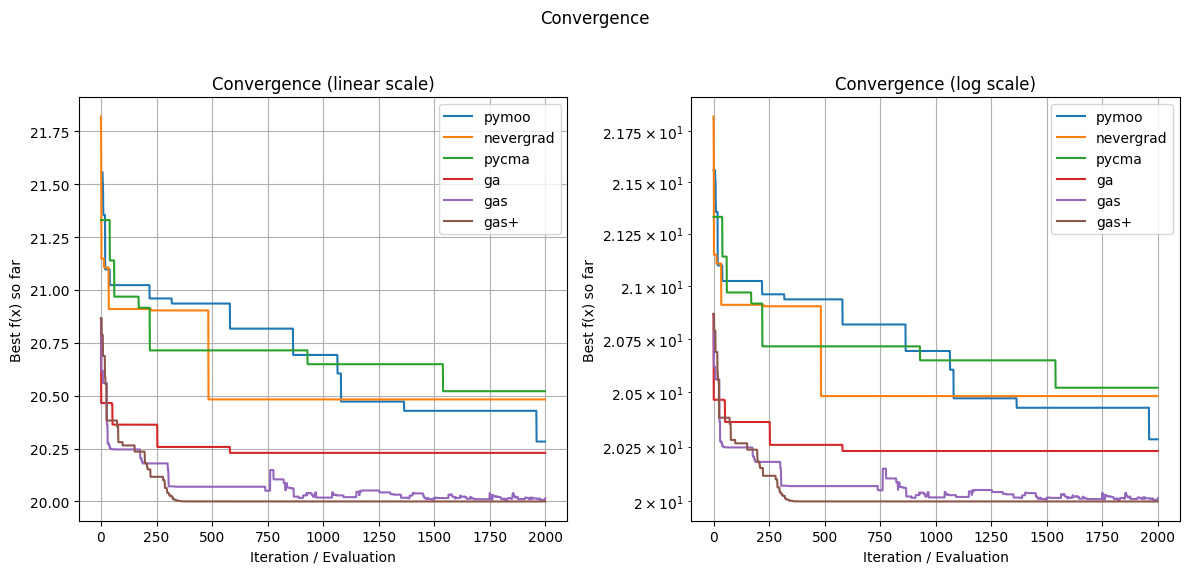

In [239]:
hist_ga = logger_ga.data[0][1]
hist_gas = logger_gas.data[0][1]
hist_gas_s = logger_gas_s.data[0][1]

plot_convergence(
    [hist_pymoo, hist_ng, hist_cma, hist_ga, hist_gas, hist_gas_s],
    ["pymoo", "nevergrad", "pycma", "ga", "gas", "gas+"],
    title="Convergence"
)